In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values to range [-1, 1]
])

# Load the training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Load the testing dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
from keras . datasets import cifar10
# Load the CIFAR -10 dataset
( train_images , train_labels ) , ( test_images ,test_labels ) = cifar10 . load_data ()

In [4]:
from torch.utils.data import random_split

# Define the ratios for splitting the dataset
total_length = len(train_dataset)
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Calculate the lengths of subsets
train_length = int(train_ratio * total_length)
val_length = int(val_ratio * total_length)
test_length = total_length - train_length - val_length

# Split the dataset into training, validation, and testing subsets
train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_length, val_length, test_length])


In [5]:
# Hyper-parameters
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Epoch [1/20] - Training Loss: 2.1786 - Validation Loss: 2.0941
Epoch [2/20] - Training Loss: 2.0802 - Validation Loss: 2.0361
Epoch [3/20] - Training Loss: 2.0375 - Validation Loss: 2.0506
Epoch [4/20] - Training Loss: 2.0116 - Validation Loss: 2.0012
Epoch [5/20] - Training Loss: 1.9936 - Validation Loss: 1.9927
Epoch [6/20] - Training Loss: 1.9804 - Validation Loss: 1.9601
Epoch [7/20] - Training Loss: 1.9613 - Validation Loss: 1.9457
Epoch [8/20] - Training Loss: 1.9418 - Validation Loss: 1.9532
Epoch [9/20] - Training Loss: 1.9288 - Validation Loss: 1.9462
Epoch [10/20] - Training Loss: 1.9181 - Validation Loss: 1.9471
Epoch [11/20] - Training Loss: 1.9064 - Validation Loss: 1.9199
Epoch [12/20] - Training Loss: 1.8942 - Validation Loss: 1.9080
Epoch [13/20] - Training Loss: 1.8798 - Validation Loss: 1.9121
Epoch [14/20] - Training Loss: 1.8693 - Validation Loss: 1.9165
Epoch [15/20] - Training Loss: 1.8680 - Validation Loss: 1.9346
Epoch [16/20] - Training Loss: 1.8581 - Validatio

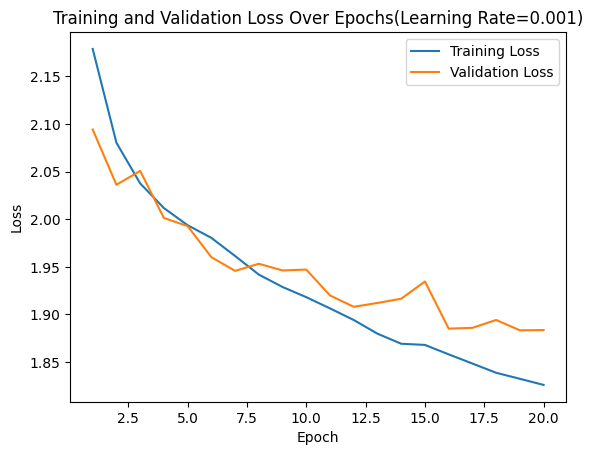

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Assuming train_loader, validation_loader, and other necessary variables are defined.

x1 = 32
m1 = 5
x2 = 64
m2 = 5
x3 = 128
d = 0.5

class ConvNet(nn.Module):
    def __init__(self, x1, m1, x2, m2, x3, d):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, x1, m1)
        self.bn1 = nn.BatchNorm2d(x1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(x1, x2, m2)
        self.bn2 = nn.BatchNorm2d(x2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(x2 * 5 * 5, x3)
        self.dropout = nn.Dropout(d)
        self.fc2 = nn.Linear(x3, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(-1, x2 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

# Assuming train_loader, validation_loader, and other necessary variables are defined.
# Initialize the model, criterion, and optimizer
model = ConvNet(x1, m1, x2, m2, x3, d)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# Set the number of training epochs
num_epochs = 20
best_validation_loss = float('inf')

train_loss_history = []
validation_loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

    validation_loss = validation_loss / len(val_loader)
    validation_loss_history.append(validation_loss)

    # Learning rate scheduler step
    scheduler.step(validation_loss)

    

    # Print training and validation loss at each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {train_loss:.4f} - Validation Loss: {validation_loss:.4f}')

# Plot the training and validation loss
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs(Learning Rate=0.001)')
plt.legend()
plt.show()


In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluation on the testing dataset
model.eval()
test_predictions = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report (Precision, Recall, F1-score, Support)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_report = classification_report(test_labels, test_predictions, target_names=class_names)
print('Classification Report:')
print(class_report)

# Calculate train accuracy (optional)
train_predictions = []
train_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_predictions)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')


Test Accuracy: 66.65%
Confusion Matrix:
[[374  40  27  21  26   3   3  17  46  39]
 [  8 524   1   5   1   2   8   2   7  50]
 [ 48  12 272  50  70  60  30  36  15   7]
 [ 11  15  27 307  40 107  35  49   5  21]
 [ 23   9  40  29 364  10  28  76   7   8]
 [  3   7  34  96  25 349  15  51   3   6]
 [  4  12  33  40  31  24 429  13   1   9]
 [  7   5  16  16  32  51   1 444   0  27]
 [ 34  43   5  19   6   4   6   0 463  41]
 [  8  56   3  14   3   3   2   9   9 473]]
Classification Report:
              precision    recall  f1-score   support

       plane       0.72      0.63      0.67       596
         car       0.72      0.86      0.79       608
        bird       0.59      0.45      0.51       600
         cat       0.51      0.50      0.51       617
        deer       0.61      0.61      0.61       594
         dog       0.57      0.59      0.58       589
        frog       0.77      0.72      0.74       596
       horse       0.64      0.74      0.69       599
        ship       

**DenseNet**

In [22]:
from keras.applications import DenseNet121
from keras import layers
from keras import models
from keras.optimizers import Adam
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


# Load DenseNet121 pre-trained on ImageNet without the top (classification) layer
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Create a new model using the DenseNet121 base
model_densenet = models.Sequential()
model_densenet.add(densenet_base)
model_densenet.add(layers.GlobalAveragePooling2D())
model_densenet.add(layers.Dense(10, activation='softmax'))  # CIFAR-10 has 10 classes

# Compile the model
model_densenet.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Fine-tune the model on CIFAR-10
model_densenet.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))


Epoch 1/10
1563/1563 [==============================] - 958s 584ms/step - loss: 1.0742 - accuracy: 0.6361 - val_loss: 0.7060 - val_accuracy: 0.7648
Epoch 2/10
1563/1563 [==============================] - 884s 565ms/step - loss: 0.6173 - accuracy: 0.7906 - val_loss: 0.5794 - val_accuracy: 0.8034
Epoch 3/10
1563/1563 [==============================] - 881s 564ms/step - loss: 0.4553 - accuracy: 0.8420 - val_loss: 0.5080 - val_accuracy: 0.8237
Epoch 4/10
1563/1563 [==============================] - 886s 567ms/step - loss: 0.3377 - accuracy: 0.8836 - val_loss: 0.4963 - val_accuracy: 0.8322
Epoch 5/10
1563/1563 [==============================] - 886s 567ms/step - loss: 0.2539 - accuracy: 0.9114 - val_loss: 0.4727 - val_accuracy: 0.8473
Epoch 6/10
1563/1563 [==============================] - 882s 565ms/step - loss: 0.1914 - accuracy: 0.9340 - val_loss: 0.5466 - val_accuracy: 0.8390
Epoch 7/10
1563/1563 [==============================] - 885s 566ms/step - loss: 0.1475 - accuracy: 0.9484 - val_

In [26]:
# Evaluate the model on the test data
test_loss, test_accuracy = model_densenet.evaluate(test_images, test_labels, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')


313/313 - 55s - loss: 0.5701 - accuracy: 0.8510 - 55s/epoch - 177ms/step
Test accuracy: 85.10%
